In [53]:
import pandas as pd
import numpy as np
import random as rnd

def titanic(train, test):
    train_df = pd.read_csv(train)
    test_df = pd.read_csv(test)
    combine = [train_df, test_df]

    train_df = train_df.drop(['Ticket', 'Cabin'], axis=1)
    test_df = test_df.drop(['Ticket', 'Cabin'], axis=1)
    combine = [train_df, test_df]

    for dataset in combine:
        dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

    pd.crosstab(train_df['Title'], train_df['Sex'])

    for dataset in combine:
        dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
        'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

        dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
        dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
        dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

    train_df[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    for dataset in combine:
        dataset['Title'] = dataset['Title'].map(title_mapping)
        dataset['Title'] = dataset['Title'].fillna(0)

    train_df = train_df.drop(['Name', 'PassengerId'], axis=1)
    test_df = test_df.drop(['Name'], axis=1)
    combine = [train_df, test_df]

    for dataset in combine:
        dataset['Sex'] = dataset['Sex'].map( {'female': 1, 'male': 0} ).astype(int)

    guess_ages = np.zeros((2,3))
    guess_ages

    for dataset in combine:
        for i in range(0, 2):
            for j in range(0, 3):
                guess_df = dataset[(dataset['Sex'] == i) & \
                                      (dataset['Pclass'] == j+1)]['Age'].dropna()

                # age_mean = guess_df.mean()
                # age_std = guess_df.std()
                # age_guess = rnd.uniform(age_mean - age_std, age_mean + age_std)

                age_guess = guess_df.median()

                # Convert random age float to nearest .5 age
                guess_ages[i,j] = int( age_guess/0.5 + 0.5 ) * 0.5

        for i in range(0, 2):
            for j in range(0, 3):
                dataset.loc[ (dataset.Age.isnull()) & (dataset.Sex == i) & (dataset.Pclass == j+1),\
                        'Age'] = guess_ages[i,j]

        dataset['Age'] = dataset['Age'].astype(int)

    for dataset in combine:
        dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1



    for dataset in combine:
        dataset['IsAlone'] = 0
        dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

    combine = [train_df, test_df]

    freq_port = train_df.Embarked.dropna().mode()[0]

    for dataset in combine:
        dataset['Embarked'] = dataset['Embarked'].fillna(freq_port)

    test_df['Fare'].fillna(test_df['Fare'].dropna().median(), inplace=True)
    
    test_df = pd.get_dummies(test_df)
    train_df = pd.get_dummies(train_df)

    test_df.head(10)
    return (train_df, test_df)

In [54]:
train = './titanic/train.csv'
test = './titanic/test.csv'
train, test = titanic(train, test)
train.head()

Survived  Pclass  Sex  Age  SibSp  Parch     Fare  Title  FamilySize  \
0         0       3    0   22      1      0   7.2500      1           2   
1         1       1    1   38      1      0  71.2833      3           2   
2         1       3    1   26      0      0   7.9250      2           1   
3         1       1    1   35      1      0  53.1000      3           2   
4         0       3    0   35      0      0   8.0500      1           1   

   IsAlone  Embarked_C  Embarked_Q  Embarked_S  
0        0           0           0           1  
1        0           1           0           0  
2        1           0           0           1  
3        0           0           0           1  
4        1           0           0           1

In [25]:
test.head()

PassengerId  Pclass  Sex  Age  SibSp  Parch     Fare  Title  FamilySize  \
0          892       3    0   34      0      0   7.8292      1           1   
1          893       3    1   47      1      0   7.0000      3           2   
2          894       2    0   62      0      0   9.6875      1           1   
3          895       3    0   27      0      0   8.6625      1           1   
4          896       3    1   22      1      1  12.2875      3           3   

   IsAlone  Embarked_C  Embarked_Q  Embarked_S  
0        1           0           1           0  
1        0           0           0           1  
2        1           0           1           0  
3        1           0           0           1  
4        0           0           0           1

In [84]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(max_depth=3)

X_train = train.iloc[:, 1:]

Y_train = train.iloc[:, 0]

clf.fit(X_train, Y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

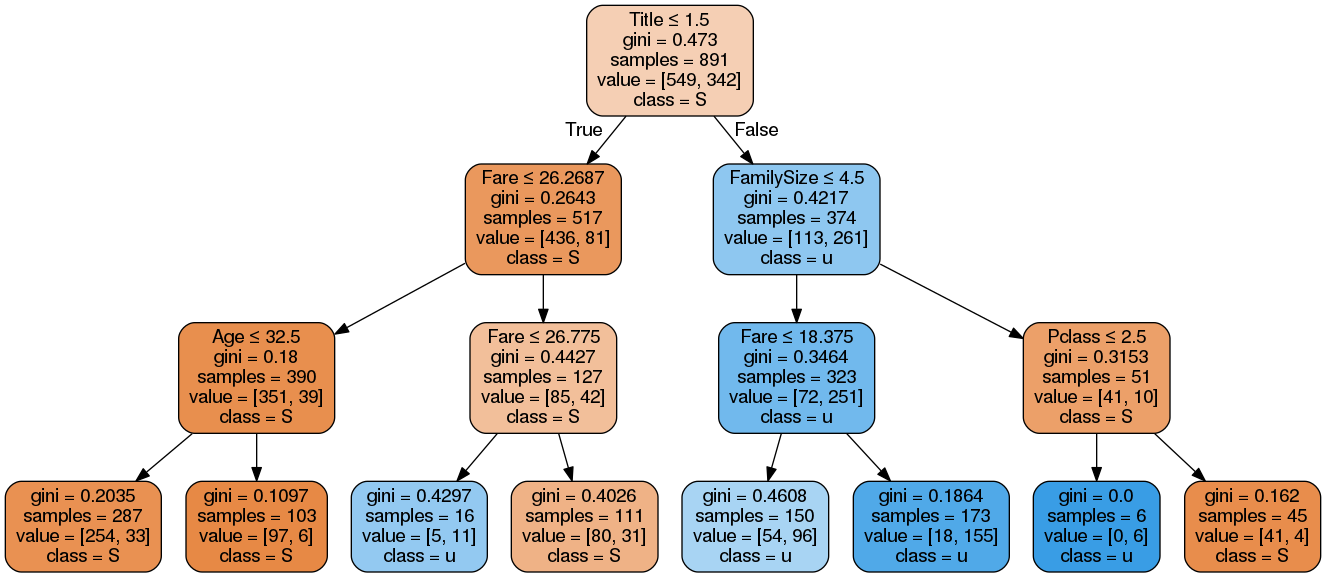

In [85]:
from sklearn import tree
from IPython.display import Image 
from StringIO import StringIO
import pydotplus

clf.fit(X_train, Y_train)


dot_data = StringIO()  
tree.export_graphviz(clf, out_file=dot_data,  
                         feature_names=X_train.columns,  
                         class_names=solutions.columns[1],  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())


In [73]:
y_predict = clf.predict(test.iloc[:, 1:])
y_predict

array([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0,
       0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0,
       0, 0,

In [88]:
# from sklearn import metrics
# from sklearn.model_selection import cross_val_predict


# predicted = cross_val_predict(clf, X_train, train, cv=10)

# metrics.accuracy_score(y_predict, predicted)

In [80]:
solutions = pd.DataFrame()
solutions['PassengerId'] = test.PassengerId
solutions['Survived'] = y_predict
solutions.head()

PassengerId  Survived
0          892         0
1          893         1
2          894         0
3          895         0
4          896         1

In [ ]:
solutions.to_csv('./survival.csv', index=False)

In [70]:
solutions.columns

Index([u'PassengerId', u'Survived'], dtype='object')